# How to create a best listing on Airbnb? A study from Seattle Airbnb listing data

In this study, we will look into the listing data from Seatlle to find most interesting facts about it.

We will focus on how to create a good listing, and what aspect impact the most on pricing, user review & popularity of a listing.

The provided data included:
- `listings.csv`: detail of the listing, include detail of rental, place, pricing, user review
- `reviews.csv`: detail of all review of places
- `calendar.csv`: detail of pricing & avaiability of listings by day

On this study, we will focus on `listings.csv` and `calendar.csv` which provided information on pricing & user scores. Where `reviews.csv` is more focus on review detail, that required the natural language processing and not included in this study yet.

## Part 1: Review & cleanup data

In [6]:
# load required library

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

In [146]:
# load data
listings_df = pd.read_csv('./data/listings.csv', parse_dates=['first_review', 'last_review', 'host_since'])
calendar_df = pd.read_csv('./data/calendar.csv', parse_dates=['date'])

In [147]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [148]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [149]:
# check columns has same values
print(listings_df['experiences_offered'].value_counts())
print(listings_df['jurisdiction_names'].value_counts())

none    3818
Name: experiences_offered, dtype: int64
WASHINGTON    3818
Name: jurisdiction_names, dtype: int64


In [150]:
# cleanup
listings_df = listings_df.drop(['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'host_url', 
                                'host_thumbnail_url', 'host_picture_url', 'city', 'state', 'zipcode', 'market',
                                'smart_location', 'country_code', 'country', 'calendar_last_scraped', 'jurisdiction_names'], axis=1)

In [151]:
# replace t/f values

listings_df[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'require_guest_profile_picture', 
             'is_location_exact', 'has_availability', 'require_guest_phone_verification', 'instant_bookable', 
             'require_guest_profile_picture', 'require_guest_phone_verification']
           ] = listings_df[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                            'require_guest_profile_picture', 'is_location_exact', 'has_availability', 
                            'require_guest_phone_verification', 'instant_bookable', 
                            'require_guest_profile_picture', 'require_guest_phone_verification']
           ].replace({'f': 0, 't': 1}).fillna(0).astype(np.int)

In [152]:
# correct price value
cleanup_price = lambda col: col.str.replace(',', '').str.replace('$', '')
listings_df[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
           ] = listings_df[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
                          ].apply(cleanup_price).astype(np.float)

In [172]:
calendar_df['price'] = cleanup_price(calendar_df['price'])

In [179]:
# cleanup response rate
#listings_df['host_response_rate'] = listings_df['host_response_rate'].str.replace('%','').astype(np.float).fillna(0)
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.replace('%','').astype(np.float).fillna(0)


In [154]:
# If nan, security_deposit and cleaning_fee should be 0
listings_df[['security_deposit', 'cleaning_fee']] = listings_df[['security_deposit', 'cleaning_fee']].fillna(0, axis=0)

In [155]:
listings_df[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,85.0,NaN,NaN,0.0,0.0,5.0
1,150.0,1000.0,3000.0,100.0,40.0,0.0
2,975.0,NaN,NaN,1000.0,300.0,25.0
3,100.0,650.0,2300.0,0.0,0.0,0.0
4,450.0,NaN,NaN,700.0,125.0,15.0


In [156]:
# testing word count function
listings_df['summary'].apply(lambda sentence: 0 if str(sentence)=='nan' else str(sentence).split().__len__()).head()

0     0
1    37
2    36
3    42
4    29
Name: summary, dtype: int64

In [157]:
# Apply word count to description-like columns
word_count = lambda sentence: 0 if str(sentence)=='nan' else str(sentence).split().__len__()
col_word_count = lambda col: col.apply(word_count)
listings_df[['summary_count', 'space_count', 'description_count', 'neighborhood_overview_count', 'notes_count', 
             'transit_count', 'thumbnail_url_exist', 'medium_url_exist', 'picture_url_exist', 'xl_picture_url_exist']
           ] = listings_df[['summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 
                            'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url']
                          ].apply(col_word_count, axis=1)

In [158]:
listings_df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,thumbnail_url,medium_url,...,summary_count,space_count,description_count,neighborhood_overview_count,notes_count,transit_count,thumbnail_url_exist,medium_url_exist,picture_url_exist,xl_picture_url_exist
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,NaN,NaN,...,0,174,174,0,0,0,0,0,1,0
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,...,37,140,146,27,166,27,1,1,1,1
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,...,36,178,169,111,28,34,0,0,1,0
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,NaN,NaN,...,42,0,42,0,0,0,0,0,1,0
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,...,29,83,171,86,1,56,0,0,1,0


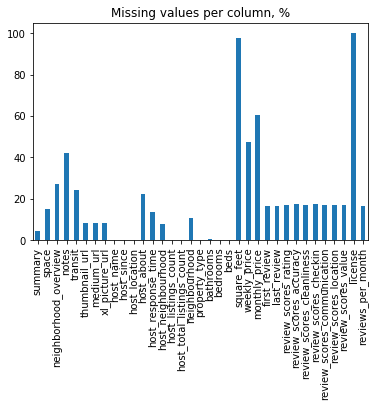

In [211]:
# percentage of missing values for each column
listings_missing_df = listings_df.isnull().mean()*100

# filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

# plot the results
listings_columns_with_nan.plot.bar(title='Missing values per column, %');

C:\Users\tienl\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


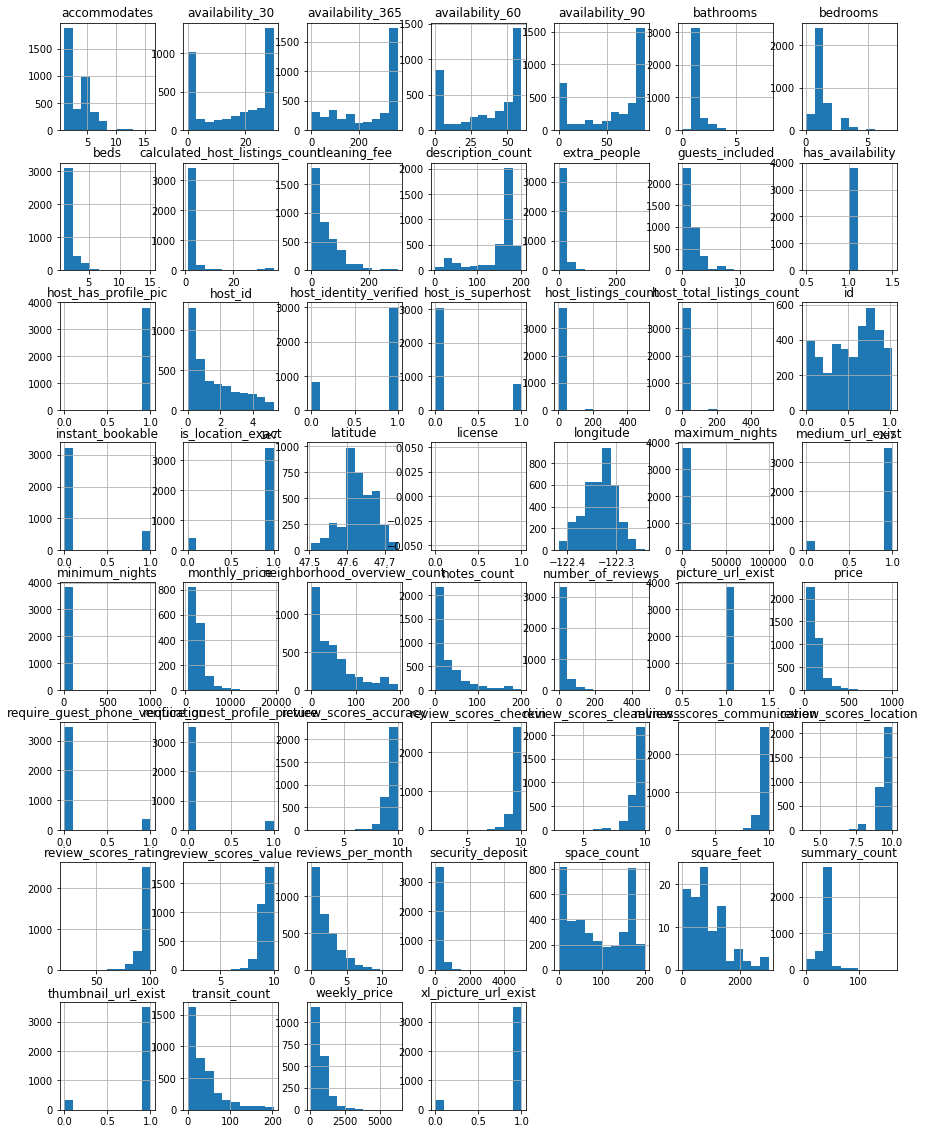

In [159]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
listings_df.hist(ax = ax);

Based on histogrram, we can have some points of interests as bellow:
1. Skewed right distribution on the room size & number of room, price in general, number of review. So in general, there are more small places & more reasonable for smaller groups. For number of review & review per month, it also skewed right, means that the popularity is spread to multiple places
2. Skewed left distribution on the review scores. So places in Seattle seam to have very good user score
3. Central (bell shaped) model for latitude and longitude. That's mean more listings are in central of Seattle than in outside
4. For Avaiability, many places are booked on short term (30, 60, 90 days). And for long term, it is the more availability.

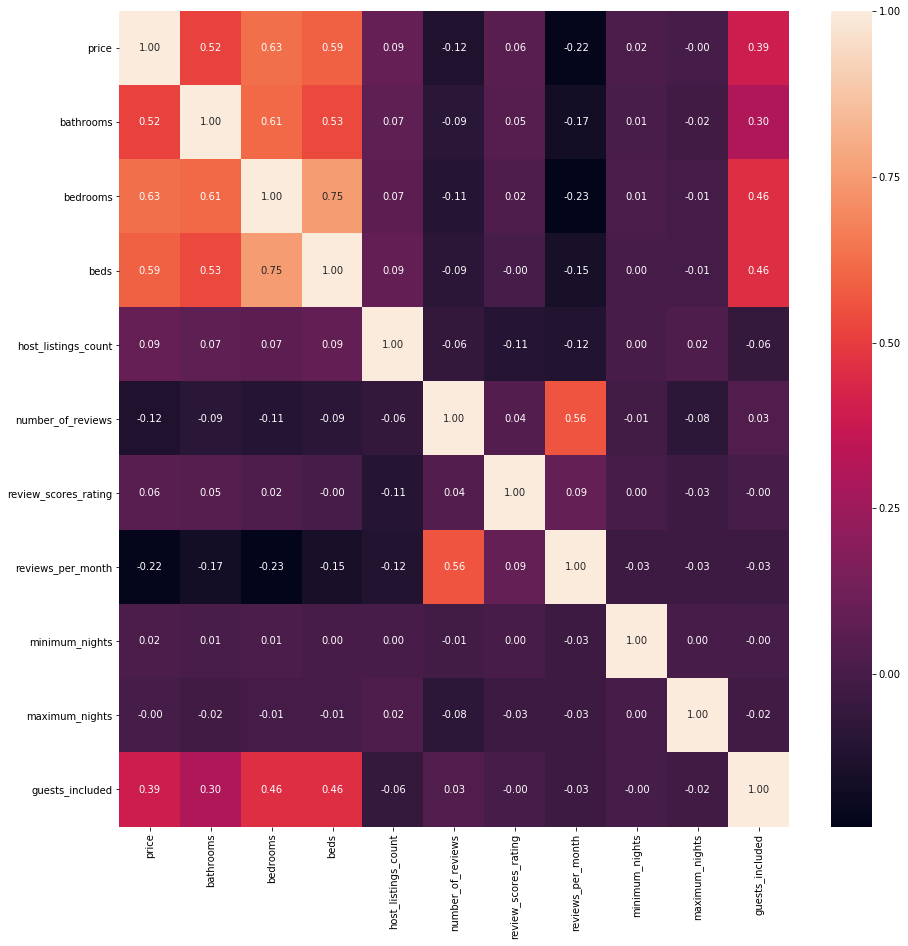

In [160]:
fig2, ax2 = plt.subplots(figsize=(15,15))
sns.heatmap(listings_df[['price', 'bathrooms', 'bedrooms', 'beds', 'host_listings_count', 'number_of_reviews',
                        'review_scores_rating', 'reviews_per_month', 'minimum_nights', 'maximum_nights', 'guests_included']
                       ].corr(), annot=True, fmt=".2f", ax=ax2);

Based on the correlation matrix heatmap, we found some points of interest as bellow:


In [161]:
listings_df[['price', 'bathrooms', 'bedrooms', 'beds', 'host_listings_count', 'number_of_reviews',
             'review_scores_rating', 'reviews_per_month', 'minimum_nights', 'maximum_nights', 'guests_included'
            ]].describe()

,price,bathrooms,bedrooms,beds,host_listings_count,number_of_reviews,review_scores_rating,reviews_per_month,minimum_nights,maximum_nights,guests_included
count,3818.000000,3802.000000,3812.000000,3817.000000,3816.000000,3818.000000,3171.000000,3191.000000,3818.000000,3818.000000,3818.000000
mean,127.976166,1.259469,1.307712,1.735394,7.157757,22.223415,94.539262,2.078919,2.369303,780.447617,1.672603
std,90.250022,0.590369,0.883395,1.139480,28.628149,37.730892,6.606083,1.822348,16.305902,1683.589007,1.311040
min,20.000000,0.000000,0.000000,1.000000,1.000000,0.000000,20.000000,0.020000,1.000000,1.000000,0.000000
25%,75.000000,1.000000,1.000000,1.000000,1.000000,2.000000,93.000000,0.695000,1.000000,60.000000,1.000000
50%,100.000000,1.000000,1.000000,1.000000,1.000000,9.000000,96.000000,1.540000,2.000000,1125.000000,1.000000
75%,150.000000,1.000000,2.000000,2.000000,3.000000,26.000000,99.000000,3.000000,2.000000,1125.000000,2.000000
max,1000.000000,8.000000,7.000000,15.000000,502.000000,474.000000,100.000000,12.150000,1000.000000,100000.000000,15.000000


In [162]:
listings_df[['summary_count', 'space_count', 'description_count', 'neighborhood_overview_count', 'notes_count', 
             'transit_count', 'thumbnail_url_exist', 'medium_url_exist', 'picture_url_exist', 'xl_picture_url_exist'
            ]].describe()

,summary_count,space_count,description_count,neighborhood_overview_count,notes_count,transit_count,thumbnail_url_exist,medium_url_exist,picture_url_exist,xl_picture_url_exist
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.0,3818.000000
mean,36.971451,90.046883,149.287061,48.193033,29.244369,38.654269,0.916186,0.916186,1.0,0.916186
std,13.532308,66.813323,46.748446,49.313864,41.320625,42.666105,0.277144,0.277144,0.0,0.277144
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,34.000000,28.000000,154.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.0,1.000000
50%,39.000000,81.000000,168.000000,36.000000,13.000000,27.000000,1.000000,1.000000,1.0,1.000000
75%,43.000000,162.750000,176.000000,71.000000,41.000000,55.000000,1.000000,1.000000,1.0,1.000000
max,164.000000,201.000000,202.000000,194.000000,202.000000,204.000000,1.000000,1.000000,1.0,1.000000


## Part 2: Price prediction

In [171]:
listings_df.columns

Index(['id', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availabil

In [213]:
#Dropping where the salary has missing values
df = listings_df.dropna(subset=['price'], axis=0
                       ).drop(
    ['id', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 
     'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_name', 'host_verifications', 
     'host_about', 'host_location', 'host_neighbourhood', 'thumbnail_url', 'medium_url',
    'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'amenities',
    'weekly_price', 'monthly_price', 'requires_license', 'license', 'name',
    'first_review', 'last_review', 'host_since', 'calendar_updated', 'has_availability',
    'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
                   'availability_60', 'availability_90', 'availability_365'], axis=1)

#fill in missing values for bathrooms, bedrooms and beds with mode
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])
# cleanup datetime
#df[['first_review', 'last_review', 'host_since']] = df[['first_review', 'last_review', 'host_since']].to_numpy().astype(np.int64)
#Drop columns with all NaN values
df = df.dropna(how='all', axis=1)
#Pull a list of the column names of the categorical variables
cat_df = df.select_dtypes(include=['object'])
cat_cols = cat_df.columns
#dummy all the cat_cols
for col in  cat_cols:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)




In [214]:
def get_predict(source_df, response_col, test_size=.30, random_state=42):
    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = source_df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables (X, y)

    X = df.drop(response_col, axis=1)
    y = df[response_col]
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Instantiate
    lm_model = LinearRegression(normalize=True)
    # Fit
    lm_model.fit(X_train, y_train) 
    # Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    # Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [215]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = get_predict(df, 'price')
print(test_score, train_score)

0.5934172819850592 0.5869277267307133


In [216]:
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,96.0,100.0,0,3.0,3.0,1,1,47.636289,-122.371025,4,...,0,0,0,0,0,0,0,1,1,0
1,98.0,100.0,1,6.0,6.0,1,1,47.639123,-122.365666,4,...,0,0,0,0,0,0,0,1,0,1
2,67.0,100.0,0,2.0,2.0,1,1,47.629724,-122.369483,11,...,0,0,0,0,0,0,0,1,0,1
3,0.0,0.0,0,1.0,1.0,1,1,47.638473,-122.369279,3,...,0,0,0,0,0,0,0,1,0,0
4,100.0,0.0,0,2.0,2.0,1,1,47.632918,-122.372471,6,...,0,0,0,0,0,0,0,1,0,1


In [217]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(30)

,est_int,coefs,abs_coefs
39,medium_url_exist,-8.794915e+12,8.794915e+12
38,thumbnail_url_exist,5.999186e+12,5.999186e+12
41,xl_picture_url_exist,2.795728e+12,2.795728e+12
4,host_total_listings_count,7.740134e+11,7.740134e+11
3,host_listings_count,-7.740134e+11,7.740134e+11
40,picture_url_exist,-2.551376e+05,2.551376e+05
46,property_type_Boat,1.136033e+02,1.136033e+02
8,longitude,-7.768883e+01,7.768883e+01
7,latitude,-6.957544e+01,6.957544e+01
56,property_type_Tent,-4.898981e+01,4.898981e+01


In [218]:
from sklearn.ensemble import RandomForestRegressor

In [220]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 453.454, test: 3309.277
Random Forest R^2 train: 0.943, test: 0.614


In [222]:
coef_df3 = coef_weights(forest.feature_importances_, X_train)

#A quick look at the top results
coef_df3.head(30)

,est_int,coefs,abs_coefs
39,medium_url_exist,-8.794915e+12,8.794915e+12
38,thumbnail_url_exist,5.999186e+12,5.999186e+12
41,xl_picture_url_exist,2.795728e+12,2.795728e+12
4,host_total_listings_count,7.740134e+11,7.740134e+11
3,host_listings_count,-7.740134e+11,7.740134e+11
40,picture_url_exist,-2.551376e+05,2.551376e+05
46,property_type_Boat,1.136033e+02,1.136033e+02
8,longitude,-7.768883e+01,7.768883e+01
7,latitude,-6.957544e+01,6.957544e+01
56,property_type_Tent,-4.898981e+01,4.898981e+01


## Part 3: Popularity prediction

In [207]:
test_score2, train_score2, lm_model2, X_train2, X_test2, y_train2, y_test2 = get_predict(df, 'reviews_per_month')


In [208]:
print(test_score2, train_score2)

0.4690928395050087 0.49024261005363556


In [209]:
#Use the function
coef_df = coef_weights(lm_model2.coef_, X_train2)

#A quick look at the top results
coef_df.head(30)

,est_int,coefs,abs_coefs
45,medium_url_exist,-8.390146e+13,8.390146e+13
47,xl_picture_url_exist,7.109028e+13,7.109028e+13
44,thumbnail_url_exist,1.281118e+13,1.281118e+13
4,host_total_listings_count,3.528406e+12,3.528406e+12
3,host_listings_count,-3.528406e+12,3.528406e+12
46,picture_url_exist,4.329678e+08,4.329678e+08
53,property_type_Boat,1.160043e+02,1.160043e+02
8,longitude,-7.629114e+01,7.629114e+01
7,latitude,-7.136178e+01,7.136178e+01
56,property_type_Camper/RV,5.404205e+01,5.404205e+01


## Part 4: Seasonal pricing